In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
# word embedding 

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding


In [204]:
#read data
df = pd.read_json("news_category.json", lines=True)

In [205]:
df

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
...,...,...,...,...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28


In [206]:
#class imbalance, will fix int later section
df['category'].value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [208]:
df=df.loc[ : ,['headline', 'category']]

In [209]:
# label education , crime etc with numeric values
cat_map=dict(enumerate(df['category'].unique()))

#flip key into value for easier access
label_map = dict([(value, key) for key, value in cat_map.items()])

In [210]:
#label_map

In [211]:
#TO GET SEQUENCES
def get_sequences(texts, tokenizer, train=True, max_seq_length=0):
    sequences = tokenizer.texts_to_sequences(texts)
    if train == True:
        max_seq_length = np.max(list(map(lambda x: len(x), sequences)))

    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding="post")
    return sequences

In [212]:
# sample 1000 from each class (class imbalance fixation)
def cat_sampler(df, label=None):
    df=df.copy()
    
    cat_samples=[]
    for category in df['category'].unique():
        cat_slice=df.query('category==@category')
        cat_samples.append(cat_slice.sample(n=1000, random_state=1))
    df=pd.concat(cat_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

    #map category to integers
    df['category']=df['category'].replace(label_map)
    
    return df
    

In [213]:
df=cat_sampler(df, label=label_map)

In [214]:
#train test split 
X=df['headline']
y=df['category']
X_train, X_test, y_train, y_test =train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)


In [216]:
#tokenizing the train dataset
vocab_size=50000
tokenizer=Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

tokenizer

In [217]:
X_train=get_sequences(X_train, tokenizer, train=True)
X_test=get_sequences(X_test, tokenizer, train=False, max_seq_length=X_train.shape[1])

In [218]:
# X_train[100]

In [219]:
#model training

embeded_vector_size=64

model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embeded_vector_size, input_length=list(X_test[0].shape)[0], name="embedding"))
model.add(Flatten())
model.add(Dense(len(label_map), activation="softmax"))


In [220]:
#model compilation

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 64)            3200000   
                                                                 
 flatten_8 (Flatten)         (None, 1792)              0         
                                                                 
 dense_8 (Dense)             (None, 41)                73513     
                                                                 
Total params: 3,273,513
Trainable params: 3,273,513
Non-trainable params: 0
_________________________________________________________________


In [221]:
model.fit(X_train, y_train, epochs=100, verbose=1)

Epoch 1/100
897/897 [==============================] - 8s 9ms/step - loss: 3.4694 - accuracy: 0.1335
Epoch 2/100
897/897 [==============================] - 8s 9ms/step - loss: 2.2607 - accuracy: 0.4896
Epoch 3/100
897/897 [==============================] - 8s 9ms/step - loss: 1.2768 - accuracy: 0.7348
Epoch 4/100
897/897 [==============================] - 8s 9ms/step - loss: 0.6958 - accuracy: 0.8746
Epoch 5/100
897/897 [==============================] - 8s 9ms/step - loss: 0.3795 - accuracy: 0.9430
Epoch 6/100
897/897 [==============================] - 8s 9ms/step - loss: 0.2107 - accuracy: 0.9745
Epoch 7/100
897/897 [==============================] - 8s 9ms/step - loss: 0.1191 - accuracy: 0.9886
Epoch 8/100
897/897 [==============================] - 8s 9ms/step - loss: 0.0678 - accuracy: 0.9948
Epoch 9/100
897/897 [==============================] - 8s 9ms/step - loss: 0.0393 - accuracy: 0.9974
Epoch 10/100
897/897 [==============================] - 8s 9ms/step - loss: 0.0233 - accura

In [222]:
# model accuracy
model.evaluate(X_test, y_test, verbose=0)[1]

0.3427363634109497

In [226]:
to_predict=np.array(["Donald trump leaves the presidency position"])
to_predict=get_sequences(to_predict, tokenizer, train=False, max_seq_length=X_train.shape[1])


In [227]:
#predict an example
y_pred = np.argmax(model.predict(to_predict), axis=1)
for category, value in label_map.items():
    if(value==y_pred[0]):
        print(category)
        break


1/1 [==============================] - 0s 14ms/step
MEDIA


In [194]:
#Accuracy 
print("Accuracy percent: {:.1f}%".format(model.evaluate(X_test, y_test, verbose=0)[1]*100))



Accuracy percent: 33.1%


385/385 [==============================] - 0s 377us/step


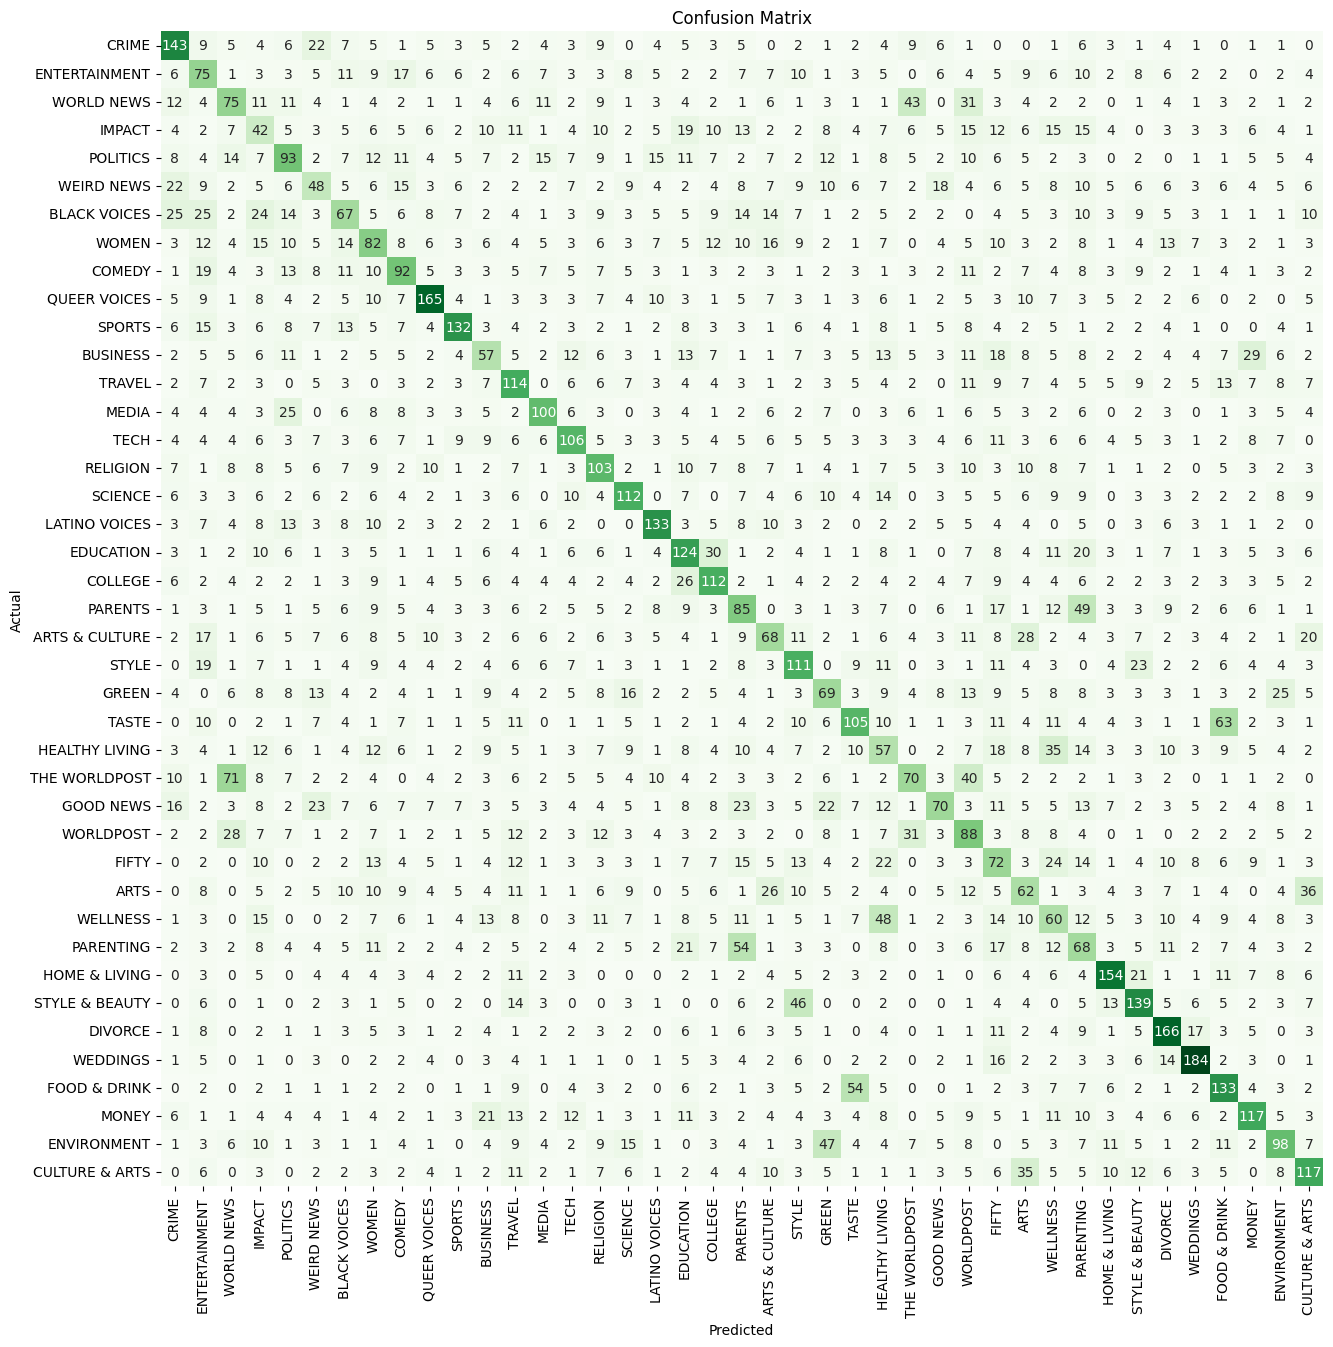

In [195]:
y_pred = np.argmax(model.predict(X_test), axis=1)
con_matrix = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=list(label_map.keys()))

plt.figure(figsize=(15, 15))
sns.heatmap(con_matrix, annot=True, vmin=0, fmt='g', cmap='Greens', cbar=False)
plt.xticks(ticks=np.arange(len(label_map)) + 0.5, labels=list(label_map.keys()), rotation=90)
plt.yticks(ticks=np.arange(len(label_map)) + 0.5, labels=list(label_map.keys()), rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix") 
plt.show()

In [196]:
print("Classification report: ", clr)

Classification report:                  precision    recall  f1-score   support

         CRIME       0.44      0.49      0.47       293
 ENTERTAINMENT       0.23      0.27      0.25       279
    WORLD NEWS       0.27      0.27      0.27       280
        IMPACT       0.14      0.14      0.14       293
      POLITICS       0.32      0.29      0.30       324
    WEIRD NEWS       0.21      0.16      0.18       302
  BLACK VOICES       0.26      0.20      0.23       329
         WOMEN       0.25      0.25      0.25       324
        COMEDY       0.32      0.33      0.32       282
  QUEER VOICES       0.55      0.50      0.52       333
        SPORTS       0.53      0.44      0.48       297
      BUSINESS       0.23      0.19      0.21       298
        TRAVEL       0.31      0.39      0.35       293
         MEDIA       0.45      0.39      0.42       259
          TECH       0.39      0.36      0.37       297
      RELIGION       0.34      0.35      0.35       291
       SCIENCE       0.